# GARCH models


In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context("notebook")

import pandas as pd
import sqlite3

from arch import arch_model

conn = sqlite3.connect(database='FCI_EIKON_long.db')

query ='SELECT * FROM "Eikon-daily" WHERE variable=="STOXXE"'
df = pd.read_sql_query(query, conn)

df = df.set_index('time', drop=True)
df.index = pd.to_datetime(df.index)
df = df.sort_index().dropna()
euro_stoxx = df.drop('variable', axis=1)
euro_stoxx.columns = ['EURO STOXX INDEX']

euro_stoxx_returns = 100 * euro_stoxx.pct_change().dropna()['2004':]
euro_stoxx_returns.columns = ['EURO STOXX Returns']

dcpi = pd.read_csv('HICP_unadj_ANR_clean.csv', index_col=0, parse_dates=True)
infl_pt = dcpi[['PT']].copy()

### GARCH(1, 1) 

$$\sigma^2_t = \omega_0 + \omega_1 \varepsilon^2_{t-1} + \varpi_1 \sigma^2_{t-1} $$

* $\omega_0>0$, $\omega_1 > 0 $, $\varpi_1 \geq 0$ (for $\sigma^2_t$ to be positive)

* restricted ARCH($\infty$)

$$
\begin{align}
\sigma^2_t &= \omega_0 + \omega_1 \varepsilon^2_{t-1} + \varpi_1 \sigma^2_{t-1}\\
           &= \omega_0 + \omega_1 \varepsilon^2_{t-1} + \varpi_1 \left( \omega_0 + \omega_1 \varepsilon^2_{t-2} + \varpi_1 \sigma^2_{t-2} \right)\\
           & \;\;\; \;\;\; \;\;\; \;\;\;\;\;\; \;\;\; \Downarrow \\
           &= \omega_0 \sum_{i=1}^{\infty }\varpi_1^i  + \omega_1 \sum_{i=1}^{\infty }\varpi^{i-1}_1 \varepsilon^2_{t-i}
\end{align}
$$

* parsimoneously (compared to ARCH(q)) introduce slowly decaying autocorrelation in $\sigma^2_t$ (seen in data)

* from

$$
\begin{align}
\varepsilon^2_{t} &= \operatorname{E}(\varepsilon^2_{t} | \varepsilon_{t-1}, \varepsilon_{t-2}, \cdots) + \nu_t\\
    &= \sigma_t^2 + \nu_t \\
&\\
\sigma^2_t &= \omega_0 + \omega_1 \varepsilon^2_{t-1} + \varpi_1 \sigma^2_{t-1}\\
& \;\;\;\;\;\;\;\;\;\;  \Downarrow \\
\varepsilon^2_{t} &= \omega_0 + (\omega_1 + \varpi_1)\varepsilon^2_{t-1} +   \nu_t - \varpi_1 \nu_{t-1}
\end{align}
$$

* ARMA(1,1) model

* stationarity: $\omega_1 + \varpi_1<1$

* $\omega_1 \neq 0$ needed for identification of $\varpi_1$. If $\omega_1 = 0$

$$ \varepsilon^2_{t} - \varpi_1\varepsilon^2_{t-1} = \omega_0  +   \nu_t - \varpi_1 \nu_{t-1} $$

is the same as 

$$ \varepsilon^2_{t}= \frac{\omega_0}{1-\varpi_1} + \nu_t $$

* unconditional mean of $\varepsilon^2_{t}$ and unconditional variance of $\varepsilon_{t}$ :

$$ \operatorname{E} \varepsilon^2_{t} = \operatorname{var}(\varepsilon_{t}) = \frac{\omega_0}{1-\omega_1 - \varpi_1} $$

* $\varepsilon_{t}$ and $z_t$ are stationary (unconditional moments are time-invariant)

### GARCH(p, q) 

$$
\begin{align}
\sigma^2_t &= \omega_0 + \sum_{i=1}^{q}\omega_i \varepsilon^2_{t-i} + \sum_{i=1}^{p} \varpi_j \sigma^2_{t-j} \\
\\
          &= \omega_0 + \omega(L) \varepsilon^2_{t} +  \varpi(L) \sigma^2_{t} \\\\
& \;\;\;\;\;\;\;\; \;\;\;\;\;\; \text{or}\\\\          
(1 &- \varpi(L)) \sigma^2_{t} = \omega_0 + \omega(L) \varepsilon^2_{t}
\end{align}
$$

* again restricted ARCH($\infty$)

$$
\begin{align}     
\sigma^2_{t} = \frac{\omega_0}{(1 - \varpi(L))} +  \frac{\omega(L)}{(1 - \varpi(L))} \varepsilon^2_{t}
\end{align}
$$

### GARCH models in Python

In [3]:
garch1 = arch_model(euro_stoxx_returns, mean='constant', vol='GARCH',  p=1, q=1)
garch1

Constant Mean(constant: yes, no. of exog: 0, volatility: GARCH(p: 1, q: 1), distribution: Normal distribution), id: 0x2ac3a608790

In [4]:
res = garch1.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     35,   Neg. LLF: 8140.923206285156
Iteration:     10,   Func. Count:     62,   Neg. LLF: 6986.150396324454
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6986.150396324485
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results                      
Dep. Variable:     EURO STOXX Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6986.15
Distribution:                  Normal   AIC:                           13980.3
Method:            Maximum Likelihood   BIC:                           14006.2
                                        No. Observations:                 4749
Date:                Mon, Apr 04 2022   Df Residuals:                     4748
Time:          

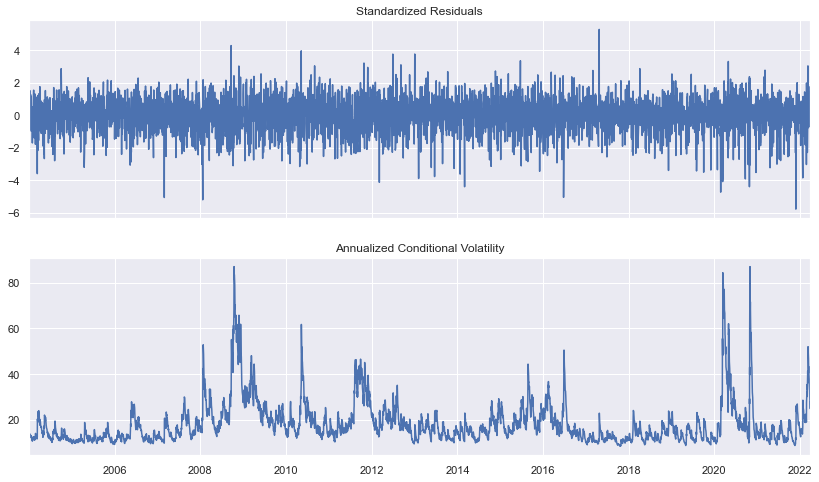

In [5]:
fig = res.plot(annualize="D")
fig.set_figheight(val=8)
fig.set_figwidth(val=14)

## GJR-GARCH models in Python

In [6]:
am = arch_model(euro_stoxx_returns, mean='constant', vol='GARCH', p=1, o=1, q=1)
res = am.fit(update_freq=5, disp="off")
print(res.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:     EURO STOXX Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -6858.73
Distribution:                  Normal   AIC:                           13727.5
Method:            Maximum Likelihood   BIC:                           13759.8
                                        No. Observations:                 4749
Date:                Mon, Apr 04 2022   Df Residuals:                     4748
Time:                        17:31:31   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0211  1.289e-02      1.635      0.102 

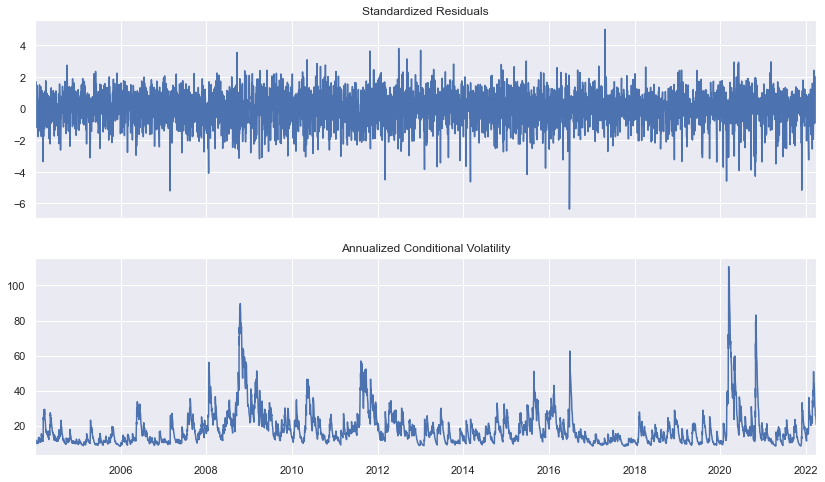

In [7]:
fig = res.plot(annualize="D")
fig.set_figheight(val=8)
fig.set_figwidth(val=14)